## 分析内容

- 正负面高频词汇
- 正负面情绪波动
- 正负面情感倾向
- 正负面LDA主题分析

## 数据清洗、预处理
文本数据，是一种非结构化数据。因此，其预处理的步骤与方式也会与结构化数据有所差异。文本数据预处理主要包括：
- 缺失值处理
- 重复值处理
- 文本内容清洗（去除指定字符）
- 分词
- 停用词处理


### 去除完全重复的数据

In [1]:
import pandas as pd
import re
import jieba.posseg as psg
import numpy as np

In [2]:
reviews = pd.read_csv('/data/reviews.csv')
reviews = reviews[['content', 'content_type']].drop_duplicates()
content = reviews['content']
reviews.head()

,content,content_type
0,东西收到这么久，都忘了去好评，美的大品牌，值得信赖，东西整体来看，个人感觉还不错，没有出现什...,pos
1,安装师傅很给力，热水器也好用，感谢美的。,pos
2,还没安装，基本满意,pos
3,电热水器收到了，京东自营商品就是好，发货速度快，品质有保障，安装效果好，宝贝非常喜欢，冬天可...,pos
4,用了几次才来评价，对产品非常满意，加热快保温时间长，售后服务特别好，主动打电话询问送货情况帮...,pos


### 去除去除英文、数字等。去除业务相关词（难以识别）

In [3]:
# 去除去除英文、数字等
# 由于评论主要为京东美的电热水器的评论，因此去除这些词语
strinfo = re.compile('[0-9a-zA-Z]|京东|美的|电热水器|热水器|')
content = content.apply(lambda x: strinfo.sub('', x))

### 进行分词、词性标注

In [4]:
# 分词、词性标注
# 自定义简单分词函数
worker = lambda s: [(x.word, x.flag) for x in psg.cut(s)] 
seg_word = content.apply(worker) 
seg_word.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/9g/qdmqnscs4dl6r9b58n_nykww0000gn/T/jieba.cache
Loading model cost 0.930 seconds.
Prefix dict has been built successfully.


0    [(东西, ns), (收到, v), (这么久, r), (，, x), (都, d), ...
1    [(安装, v), (师傅, nr), (很, d), (给, p), (力, n), (，...
2    [(还, d), (没, v), (安装, v), (，, x), (基本, n), (满意...
3    [(收到, v), (了, ul), (，, x), (自营, vn), (商品, n), ...
4    [(用, p), (了, ul), (几次, m), (才, d), (来, v), (评价...
Name: content, dtype: object

### 将词语转为DataFrame；删除标点符号

In [5]:
# 将词语转为dataframe形式，一列是词，一列是词语所在的句子ID，最后一列是词语在该句子的位置
# 每一评论中词的个数
n_word = seg_word.apply(lambda x: len(x))  
n_content = [[x+1]*y for x,y in zip(list(seg_word.index), list(n_word))]

# 将嵌套的列表展开，作为词所在评论的id
index_content = sum(n_content, [])  
seg_word = sum(seg_word, [])

# 词列表
word = [x[0] for x in seg_word]  

# 词性列表
nature = [x[1] for x in seg_word]  

# 评论类型
content_type = [[x]*y for x,y in zip(list(reviews['content_type']), list(n_word))]
content_type = sum(content_type, [])  

result = pd.DataFrame({"index_content":index_content, 
                       "word":word,
                       "nature":nature,
                       "content_type":content_type}) 

# 删除标点符号
result = result[result['nature'] != 'x']  # x表示标点符号
result.head()

,index_content,word,nature,content_type
0,1,东西,ns,pos
1,1,收到,v,pos
2,1,这么久,r,pos
4,1,都,d,pos
5,1,忘,v,pos


### 删除停用词

In [6]:
# 删除停用词，导入停用词词库
stop_path = open("/data/stoplist.txt", 'r',encoding='UTF-8')
stop = stop_path.readlines()
stop = [x.replace('\n', '') for x in stop]
word = list(set(word) - set(stop))
result = result[result['word'].isin(word)]

In [7]:
# 构造各词在对应评论的位置列
n_word = list(result.groupby(by = ['index_content'])['index_content'].count())

index_word = [list(np.arange(0, y)) for y in n_word]

# 表示词语在该评论的位置
index_word = sum(index_word, [])  

# 合并评论id，评论中词的id，词，词性，评论类型
result['index_word'] = index_word

## 数据探索

### 名词探索

In [8]:
ind = result[['n' in x for x in result['nature']]]
ind.head()

,index_content,word,nature,content_type,index_word
0,1,东西,ns,pos,0
11,1,品牌,n,pos,5
14,1,信赖,n,pos,7
16,1,东西,ns,pos,8
17,1,整体,n,pos,9


### 绘制名词词云查看效果

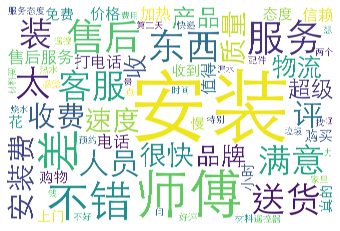

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

frequencies = result.groupby(by = ['word'])['word'].count()
frequencies = frequencies.sort_values(ascending = False)
wordcloud = WordCloud(font_path='/System/Library/Fonts/STHeiti Light.ttc',
                      max_words=70,
                      height=800, # 高度设置为600
                      width=1200, # 宽度设置为1000
                      scale=20,
                      background_color='white'
                     )
my_wordcloud = wordcloud.fit_words(frequencies)
plt.imshow(my_wordcloud)
plt.axis('off') 
plt.show()

### 修正情感倾向，绘制正面/负面情感词词云

In [10]:
# 匹配情感词
word = pd.read_csv("/data/word.csv")

# 读入正面、负面情感评价词
pos_comment = pd.read_csv("/data/正面评价词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv("/data/负面评价词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv("/data/正面情感词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv("/data/负面情感词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python') 

# 合并情感词与评价词，set取并集
positive = set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
negative = set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])


intersection = positive&negative  
positive = list(positive - intersection)
negative = list(negative - intersection)
positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)}) 

posneg = positive.append(negative)

# 将分词结果与正负面情感词表合并，定位情感词
data_posneg = posneg.merge(word, left_on = 'word', right_on = 'word', 
                           how = 'right')
data_posneg = data_posneg.sort_values(by = ['index_content','index_word'])

In [11]:
# 修正情感倾向

# 根据情感词前时候有否定词或双层否定词对情感值进行修正
# 载入否定词表
notdict = pd.read_csv("/data/not.csv")

# 处理否定修饰词
# 构造新列，作为经过否定词修正后的情感值
data_posneg['amend_weight'] = data_posneg['weight']  
data_posneg['id'] = np.arange(0, len(data_posneg))

# 只保留有情感值的词语
only_inclination = data_posneg.dropna()  
only_inclination.index = np.arange(0, len(only_inclination))
index = only_inclination['id']

for i in np.arange(0, len(only_inclination)):
    review = data_posneg[data_posneg['index_content'] == 
                         only_inclination['index_content'][i]]  # 提取第i个情感词所在的评论
    review.index = np.arange(0, len(review))
    affective = only_inclination['index_word'][i]  # 第i个情感值在该文档的位置
    if affective == 1:
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -\
            data_posneg['weight'][index[i]]          
    elif affective > 1:
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1, 
                  affective - 2]]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -\
            data_posneg['weight'][index[i]]
            
# 更新只保留情感值的数据
only_inclination = only_inclination.dropna()

# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],as_index=False)['amend_weight'].sum()
                                           

# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]


# 查看情感分析效果

# 给情感值大于0的赋予评论类型（content_type）为pos,小于0的为neg
emotional_value['a_type'] = ''
emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'

# 查看情感分析结果
result = emotional_value.merge(word, 
                               left_on = 'index_content', 
                               right_on = 'index_content',
                               how = 'left')

result = result[['index_content','content_type', 'a_type']].drop_duplicates() 
confusion_matrix = pd.crosstab(result['content_type'], result['a_type'], 
                               margins=True)  # 制作交叉表
(confusion_matrix.iat[0,0] + confusion_matrix.iat[1,1])/confusion_matrix.iat[2,2]

# 提取正负面评论信息
ind_pos = list(emotional_value[emotional_value['a_type'] == 'pos']['index_content'])
ind_neg = list(emotional_value[emotional_value['a_type'] == 'neg']['index_content'])
posdata = word[[i in ind_pos for i in word['index_content']]]
negdata = word[[i in ind_neg for i in word['index_content']]]

<ipython-input-11-85068a69fe97>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
<ipython-input-11-85068a69fe97>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'


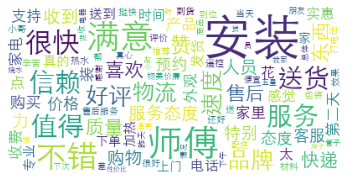

In [12]:
# 绘制词云
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud


# 正面情感词词云
freq_pos = posdata.groupby(by = ['word'])['word'].count()
freq_pos = freq_pos.sort_values(ascending = False)
# backgroud_Image=plt.imread('../data/pl.jpg')
wordcloud = WordCloud(font_path='/System/Library/Fonts/STHeiti Light.ttc',
                      max_words=100,
                      background_color='white'
                      )
pos_wordcloud = wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off') 
plt.show()

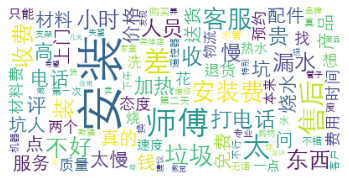

In [13]:
# 负面情感词词云
freq_neg = negdata.groupby(by = ['word'])['word'].count()
freq_neg = freq_neg.sort_values(ascending = False)
neg_wordcloud = wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off') 
plt.show()

### snowNLP 查看整体情感倾向
#### 查看整体情绪频数分布

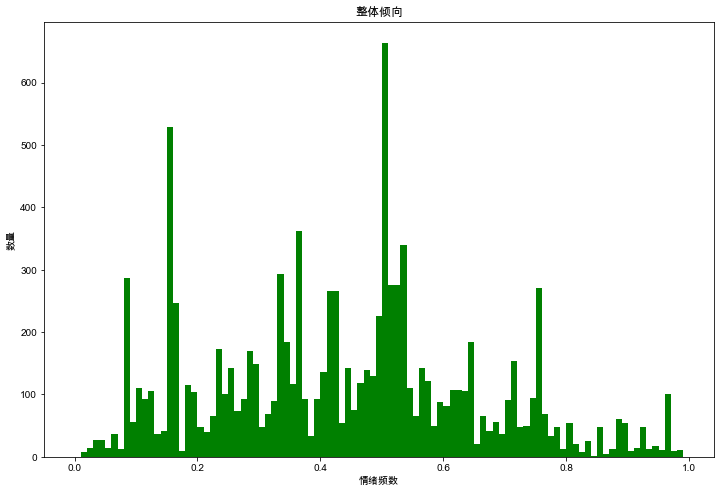

In [14]:
from snownlp import SnowNLP
sentimentslist = []
for i in ind.word:
    s = SnowNLP(i)
    sentimentslist.append(s.sentiments)

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = ['Arial Unicode MS'] 
plt.figure(figsize=(12,8))


plt.hist(sentimentslist, bins = np.arange(0, 1, 0.01), facecolor = 'g')
plt.xlabel('情绪频数')
plt.ylabel('数量')
plt.title('整体倾向')
plt.show()

#### 查看整体情绪波动

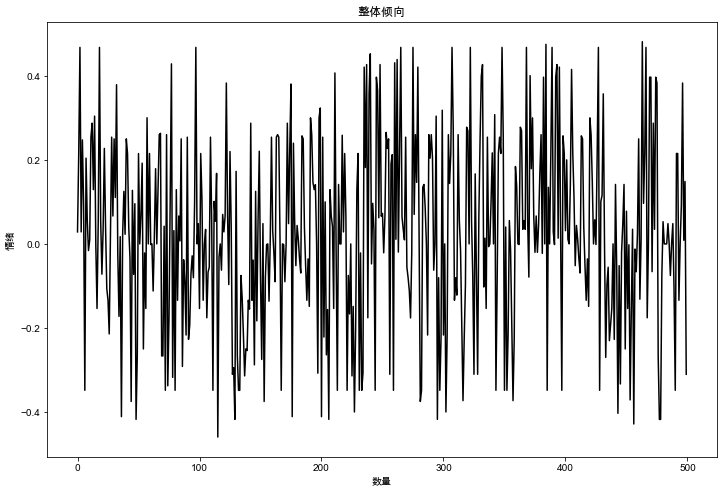

In [15]:
result = []
i = 0
while i<len(sentimentslist[:500]):
    result.append(sentimentslist[i]-0.5)
    i = i + 1

#可视化画图
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

# import numpy as np
plt.plot(result, 'k-')
plt.xlabel('数量')
plt.ylabel('情绪')
plt.title('整体倾向')
plt.show()

### 文本向量化（TfidfVectorizer, CountVectorizer）

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
n_features = 1000
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(ind.word)
tf_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.5, max_features=1000, min_df=10,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### LDA主题分析

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [18]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [19]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
信赖 上门 服务态度 材料费 时间 管子 建议 差劲 封顶 谢谢 商品 客服 地方 产品 电器 购物 师傅 正品 小哥 评差
Topic #1:
速度 物流 品牌 热水 遥控器 实惠 商品 客服 地方 产品 电器 购物 师傅 小哥 正品 评差 检查 漏电 麻烦 父母
Topic #2:
服务 东西 遥控 专业 热情 商城 宝贝 关键 信任 商品 客服 地方 产品 电器 购物 师傅 正品 小哥 评差 检查
Topic #3:
师傅 客服 产品 购物 商品 电器 地方 小哥 正品 评差 检查 漏电 麻烦 父母 消费者 理由 机子 块钱 架子 螺丝
Topic #4:
电话 配件 烧水 评价 客户 牌子 办法 角阀 差评 老人 海尔 大气 老家 花钱 花洒 水压 消费 生气 无线 农村
Topic #5:
质量 材料 垃圾 机器 公司 厂家 性价比 乱收费 回家 标准 玩意 五星 技术 太阳能 卖家 货物 咨询 客服 商品 地方
Topic #6:
价格 实体店 水管 坑人 朋友 降价 外观 支架 保温 网购 总体 活动 水阀 评论 家人 商家 图片 细心 价格公道 商品
Topic #7:
售后 人员 免费 块钱 情况 消费者 螺丝 理由 架子 评差 父母 机子 卫生间 功能 整体 麻烦 漏电 检查 客服 商品
Topic #8:
态度 小时 感觉 下单 安装工 自营 样子 美观 品质 阀门 太坑 容量 收货 商品 客服 地方 产品 电器 购物 师傅
Topic #9:
安装费 收费 费用 漏水 效果 发货 体验 管件 温度 太贵 插座 过程 顾客 恶心 不合理 力给力 冷水 客服 商品 地方



### pyLDAvis可视化

In [20]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

data = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.show(data)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
127.0.0.1 - - [19/Oct/2020 16:13:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Oct/2020 16:13:43] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [19/Oct/2020 16:13:43] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [19/Oct/2020 16:13:44] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [19/Oct/2020 16:13:44] code 404, message Not Found
127.0.0.1 - - [19/Oct/2020 16:13:44] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


### 建立词典、语料库（区分正面/负面评价）

In [28]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt

# 载入情感分析后的数据
posdata = pd.read_csv("/data/posdata.csv", encoding = 'utf-8')
negdata = pd.read_csv("/data/negdata.csv", encoding = 'utf-8')

from gensim import corpora, models
# 建立词典
pos_dict = corpora.Dictionary([[i] for i in posdata['word']])  # 正面
neg_dict = corpora.Dictionary([[i] for i in negdata['word']])  # 负面

# 建立语料库，生成词袋向量
pos_corpus = [pos_dict.doc2bow(j) for j in [[i] for i in posdata['word']]]  # 正面
neg_corpus = [neg_dict.doc2bow(j) for j in [[i] for i in negdata['word']]]   # 负面

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### LDA主题分析（正面评价/负面评价）

In [29]:
# LDA主题分析
# 正面评价主题分析
pos_lda = models.LdaModel(pos_corpus, num_topics = 3, id2word = pos_dict)  
neg_lda = models.LdaModel(neg_corpus, num_topics = 3, id2word = neg_dict)  

pos_lda.print_topics(num_words = 10)

[(0,
  '0.124*"安装" + 0.041*"师傅" + 0.030*"送货" + 0.025*"很快" + 0.018*"售后" + 0.014*"送" + 0.012*"家里" + 0.010*"赞" + 0.010*"收" + 0.009*"快递"'),
 (1,
  '0.028*"不错" + 0.022*"客服" + 0.020*"东西" + 0.017*"物流" + 0.016*"购物" + 0.016*"太" + 0.014*"速度" + 0.014*"电话" + 0.014*"品牌" + 0.011*"小时"'),
 (2,
  '0.058*"满意" + 0.029*"服务" + 0.025*"值得" + 0.023*"好评" + 0.019*"信赖" + 0.018*"人员" + 0.016*"差" + 0.013*"装" + 0.012*"质量" + 0.012*"真的"')]

In [30]:
# 负面评价主题分析
neg_lda.print_topics(num_words = 10)

[(0,
  '0.021*"东西" + 0.017*"收" + 0.015*"加热" + 0.014*"漏水" + 0.012*"坑人" + 0.012*"真的" + 0.011*"坑" + 0.011*"服务" + 0.011*"问" + 0.009*"免费"'),
 (1,
  '0.134*"安装" + 0.033*"垃圾" + 0.033*"师傅" + 0.027*"差" + 0.019*"装" + 0.019*"小时" + 0.018*"不好" + 0.017*"贵" + 0.016*"慢" + 0.016*"烧水"'),
 (2,
  '0.032*"售后" + 0.032*"太" + 0.026*"安装费" + 0.021*"客服" + 0.018*"收费" + 0.018*"打电话" + 0.014*"人员" + 0.012*"材料" + 0.012*"配件" + 0.011*"上门"')]